# Practice3 (test_submission1_4, 2_4.csv)
> Public Score
> - test_submission1_3: 25136.09206
> - test_submission2_3: 28583.13469

In [1]:
import sys, os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# column 보기 30개로 설정
pd.set_option('display.max_columns', 30)

In [2]:
# 데이터 경로 설정
file_path = os.path.join(os.getcwd(), 'data')
train_origin = pd.read_csv(file_path+'\dataset.csv')
test_origin = pd.read_csv(file_path+'\problem.csv')

In [3]:
train_origin.shape, test_origin.shape

((1340, 24), (130, 23))

In [4]:
# 전처리를 위한 원본 데이터 복사
train = train_origin.copy()
test = test_origin.copy()

In [5]:
# 메모리를 효율적으로 사용하기 위한 downcast 함수 정의
def downcast(df, verbose=True):     # verbose 옵션 추가: (True)인 경우 몇 퍼센트 압축됐는지 출력
    start_mem = df.memory_usage().sum() / 1024**2   # 초기 메모리 사용량
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print(f'{(100*(start_mem - end_mem) / start_mem):.1f}% 압축됨')

    return df

In [6]:
downcast(train)
downcast(test)

67.2% 압축됨
68.7% 압축됨


Id  LotArea Street LotConfig  OverallQual  OverallCond  YearBuilt  \
0    1341    11200   Pave    Inside            5            5       1965   
1    1342     7200   Pave    Corner            5            7       1951   
2    1343    16905   Pave    Inside            5            6       1959   
3    1344     9180   Pave   CulDSac            5            7       1983   
4    1345     7200   Pave    Inside            5            7       1920   
..    ...      ...    ...       ...          ...          ...        ...   
125  1466    11478   Pave    Inside            8            5       2007   
126  1467    16321   Pave   CulDSac            5            6       1957   
127  1468     6324   Pave    Inside            4            6       1927   
128  1469     8500   Pave    Inside            4            4       1920   
129  1470     8544   Pave   CulDSac            5            6       1966   

     YearRemodAdd  TotalBsmtSF  1stFlrSF  2ndFlrSF  GrLivArea  FullBath  \
0            1965         1040      1040         0       1040         1   
1            2000          900       900         0        900         1   
2            1959         1350      1328         0       1328         1   
3            1983          840       884         0        884         1   
4            1996          530       581       530       1111         1   
..            ...          ...       ...       ...        ...       ...   
125          2008         1704      1704         0       1704         2   
126          1997         1484      1600         0       1600         1   
127          1950          520       520         0        520         1   
128          1950          649       649       668       1317         1   
129          2006         1228      1228         0       1228         1   

     HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  \
0           0             3             1             5           0   
1           0             3             1             5           0   
2           1             2             1             5           2   
3           0             2             1             5           0   
4           0             3             1             6           0   
..        ...           ...           ...           ...         ...   
125         0             3             1             7           1   
126         0             2             1             6           2   
127         0             1             1             4           0   
128         0             3             1             6           0   
129         1             3             1             6           0   

    GarageType  GarageYrBlt  GarageCars  GarageArea  YrSold  
0       Detchd         1965           1         384    2008  
1       Detchd         2005           2         576    2010  
2       Attchd         1959           1         308    2007  
3       Attchd         1983           2         504    2007  
4       Detchd         1935           1         288    2007  
..         ...          ...         ...         ...     ...  
125     Attchd         2008           3         772    2010  
126     Attchd         1957           1         319    2006  
127     Detchd         1920           1         240    2008  
128     Detchd         1920           1         250    2008  
129     Attchd         1966           1         271    2008  

[130 rows x 23 columns]

# 전처리

### 결측치 처리

In [7]:
train.isnull().sum()

Id               0
LotArea          0
Street           0
LotConfig        0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
GrLivArea        0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageType      81
GarageYrBlt     81
GarageCars       0
GarageArea       0
YrSold           0
SalePrice        0
dtype: int64

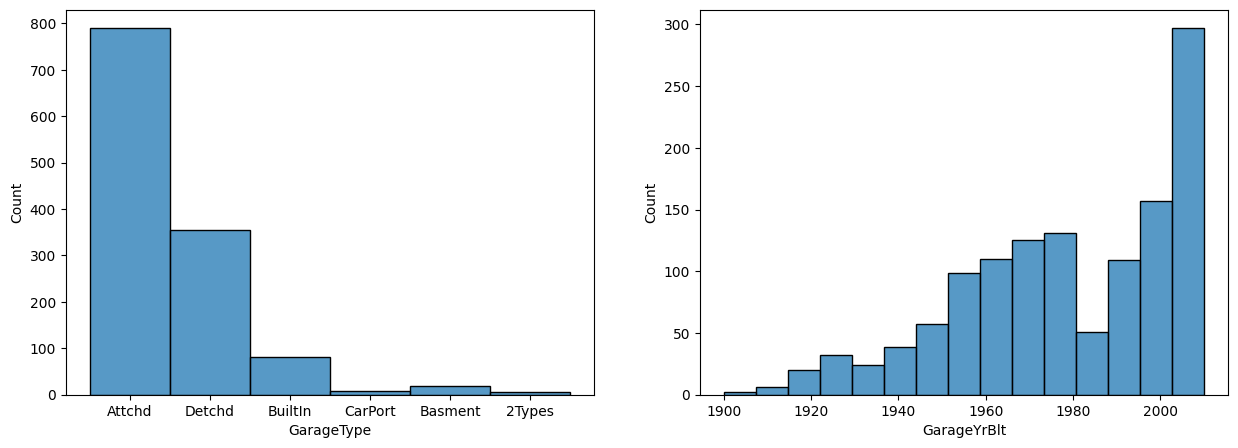

In [8]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)    # 히스토그램
sns.histplot(train['GarageType'])

plt.subplot(1, 2, 2)    # 히스토그램
sns.histplot(train['GarageYrBlt'])

plt.show()

In [9]:
# 최빈값 대체
train['GarageType'].fillna(train['GarageType'].mode()[0], inplace=True)
train['GarageYrBlt'].fillna(train['GarageYrBlt'].mode()[0], inplace=True)

In [10]:
train.isnull().sum().sum(), test.isnull().sum().sum()

(0, 0)

### Feature engineering

In [11]:
train['YearBuilt'].max()      # 최신에 지어진 건물 연도 확인

2010

In [12]:
# 2011년을 기준으로 건물이 지어진 후 지난 시간(연)
train['YearBuiltDiff'] = 2011 - train['YearBuilt']
test['YearBuiltDiff'] = 2011 - test['YearBuilt']

In [13]:
train['YearRemodAdd'].max()     # 리모델링 연도 확인

2010

In [14]:
# 리모델링 여부 및 리모델링 후 지난 시간(연)
train['RemodAddDiff'] = 2011 - train['YearRemodAdd']
test['RemodAddDiff'] = 2011 - test['YearRemodAdd']

### 일부 feature 제거

In [15]:
no_use_features = ['Id', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold', '1stFlrSF', '2ndFlrSF', 'GarageArea', 'TotRmsAbvGrd']

In [16]:
train.drop(no_use_features, axis=1, inplace=True)
test.drop(no_use_features, axis=1, inplace=True)

### 중복 데이터 제거

In [17]:
train.duplicated().sum()    # 중복 데이터 확인

2

In [18]:
train = train.drop_duplicates()     # 중복 데이터 제거

### 이상치 처리
> target 값인 SalePrice와 그와 상관관계가 매우 높은 몇 가지 feature만 이상치 처리를 좀 해주자.

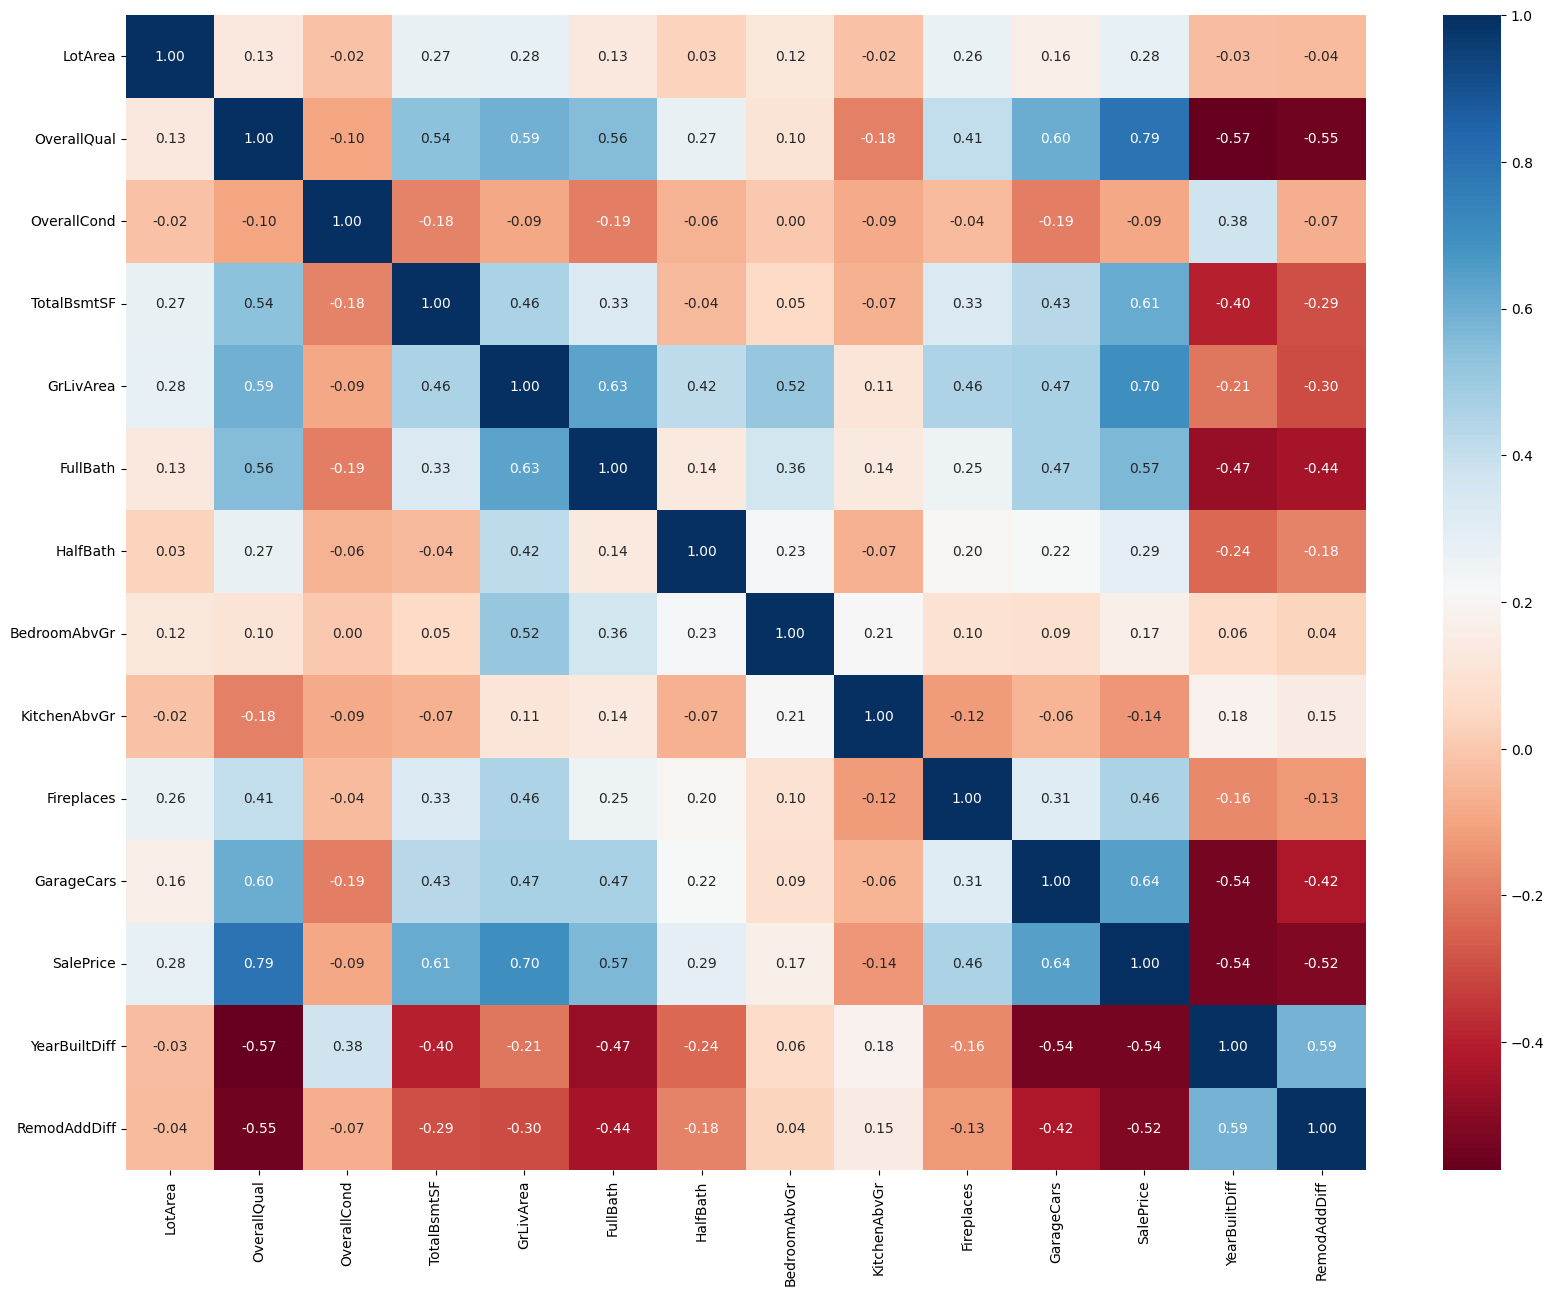

In [19]:
# 상관계수 히트맵
numeric_data = train.select_dtypes(exclude="object")   # 수치형 데이터만 추출
plt.figure(figsize=(20, 15))
sns.heatmap(numeric_data.corr(), annot=True, fmt='.2f', cmap='RdBu')    # cmap: 색상  # 절반만 표시하고 싶은 경우 mask=mask 옵션 추가
plt.show()

In [20]:
len(train.columns)

17

> GrLivArea

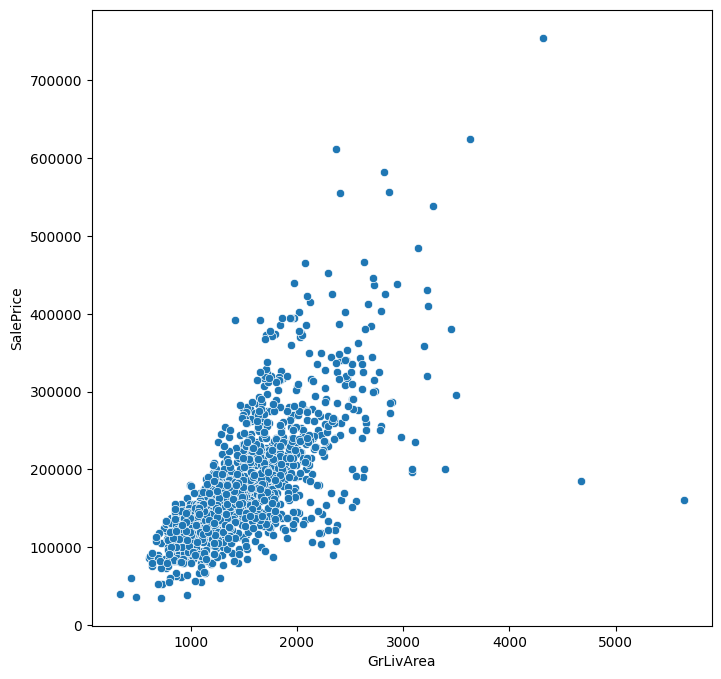

In [21]:
# GrLivArea와 SalePrice scatterplot
plt.figure(figsize=(8, 8))
sns.scatterplot(data=train, x='GrLivArea', y='SalePrice')
plt.show()

In [22]:
# 이상치 제거
outlier_index = train[(train['SalePrice']<220000)&(train['GrLivArea']>4000)]
train = train.drop(outlier_index.index).reset_index(drop=True)

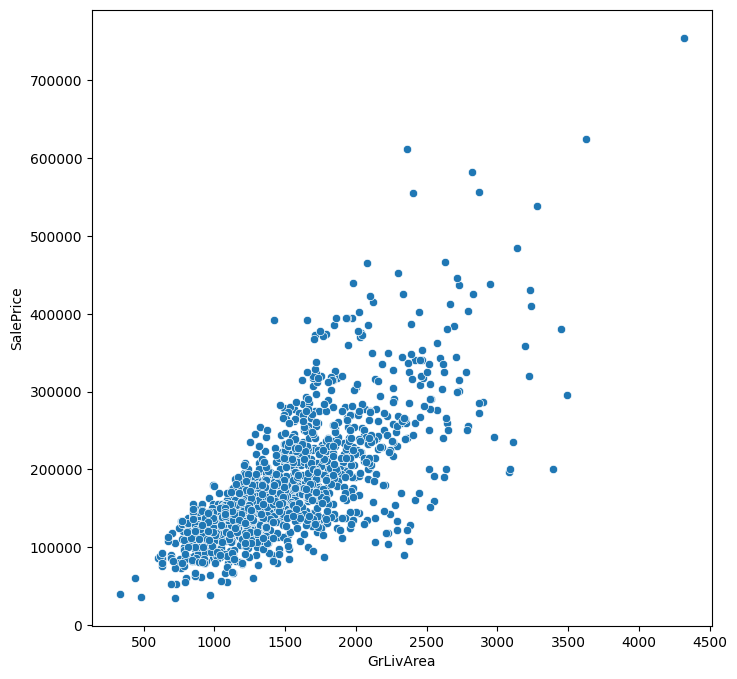

In [23]:
# GrLivArea와 SalePrice scatterplot
plt.figure(figsize=(8, 8))
sns.scatterplot(data=train, x='GrLivArea', y='SalePrice')
plt.show()

> TotalBsmtSF

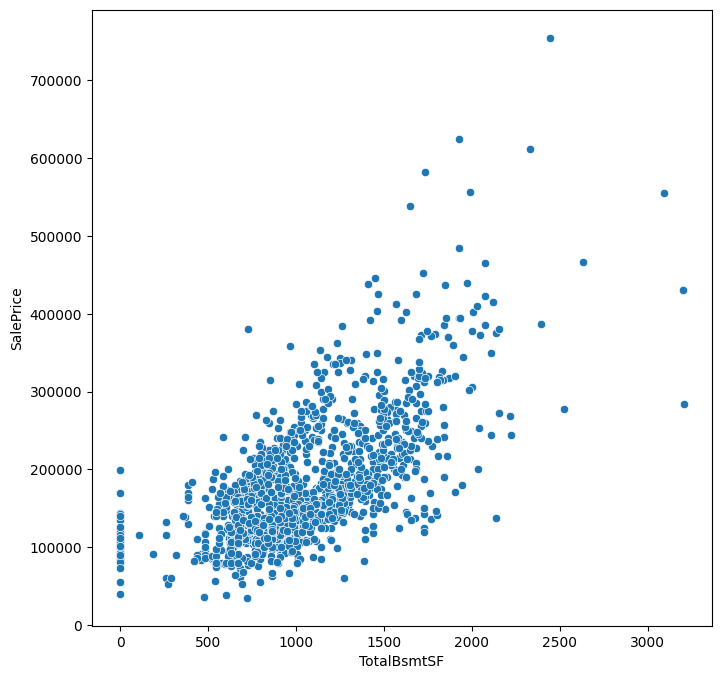

In [24]:
# OverallQual과 SalePrice scatterplot
plt.figure(figsize=(8, 8))
sns.scatterplot(data=train, x='TotalBsmtSF', y='SalePrice')
plt.show()

### Encoding

In [25]:
# X, y 분리
X_train = train.drop(columns='SalePrice', axis=1)
y_train = train['SalePrice']

In [26]:
all_data = pd.concat([X_train, test], axis=0).reset_index(drop=True)

In [27]:
all_data['LotArea'] = np.log1p(all_data['LotArea'])

In [28]:
# 일부 category는 OHE
OHE_cat = ['Street', 'LotConfig', 'GarageType']

all_data = pd.get_dummies(all_data, columns=OHE_cat)

In [29]:
# 편향 데이터 처리하기(log scale & box-cox)
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

In [30]:
# from sklearn.preprocessing import RobustScaler

# scaler = RobustScaler()

# X_train_scaled = scaler.fit_transform(X_train)
# test_scaled = scaler.transform(test)

In [31]:
X_train_scaled = all_data.iloc[:len(X_train)]
test_scaled = all_data.iloc[len(X_train):].reset_index(drop=True)

# Model training

### XGBoost

In [36]:
# 베이지안 최적화
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=10))
    return rmse, rmse.mean()

param_bounds = {
    'learning_rate' : (0.001, 0.5),
    'max_leaves': (2, 1024),
    'n_estimators': (100, 1000),
    'gamma': (0, 10),
    'max_depth': (3, 15),
    'min_child_weight': (1, 10),
    }

def eval_function(max_leaves, learning_rate, n_estimators, gamma, max_depth, min_child_weight):
    params = {
        'learning_rate' : learning_rate, 
        'max_leaves': int(max_leaves),
        'n_estimators': int(n_estimators),
        'gamma': gamma,
        'max_depth': int(max_depth),
        'min_child_weight': min_child_weight,
    }

    xgb_model = XGBRegressor(**params, random_state=42)
    score, mean_score = rmse_cv(xgb_model)
    return -mean_score

In [33]:
from bayes_opt import BayesianOptimization

optimizer = BayesianOptimization(f=eval_function, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=20)

|   iter    |  target   |   gamma   | learni... | max_depth | max_le... | min_ch... | n_esti... |
-------------------------------------------------------------------------------------------------
| 1         | -2.95e+04 | 3.745     | 0.4754    | 11.78     | 613.8     | 2.404     | 240.4     |
| 2         | -2.972e+0 | 0.5808    | 0.4332    | 10.21     | 725.7     | 1.185     | 972.9     |
| 3         | -2.694e+0 | 8.324     | 0.107     | 5.182     | 189.4     | 3.738     | 572.3     |
| 4         | -2.721e+0 | 4.319     | 0.1463    | 10.34     | 144.6     | 3.629     | 429.7     |
| 5         | -2.758e+0 | 4.561     | 0.3928    | 5.396     | 527.5     | 6.332     | 141.8     |
| 6         | -2.624e+0 | 8.581     | 0.1575    | 5.349     | 529.4     | 9.192     | 139.2     |
| 7         | -2.718e+0 | 8.157     | 0.2517    | 11.3      | 527.2     | 4.666     | 130.9     |
| 8         | -2.641e+0 | 7.37      | 0.134     | 4.606     | 189.8     | 5.002     | 563.2     |
| 9         | -2.698

In [34]:
# 최적화된 하이퍼파라미터로 모델 재학습
best_params = {
    'n_estimators': round(optimizer.max['params']['n_estimators']),
    'max_depth': round(optimizer.max['params']['max_depth']),
    'max_leaves': round(optimizer.max['params']['max_leaves']),
    'min_child_weight': round(optimizer.max['params']['min_child_weight']),
    'learning_rate': optimizer.max['params']['learning_rate'],
    'gamma': optimizer.max['params']['gamma'],
}

best_xgb = XGBRegressor(**best_params, random_state=42)
score, mean_score = rmse_cv(best_xgb)
print(score)
print(mean_score)

[26228.66648152 21242.10267571 24332.4833091  29961.28792393
 35883.19297149 23513.87662405 24526.36708534 19196.46073401
 25508.99108324 25400.65749138]
25579.408637976965


In [94]:
best_xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=8.580780722249438, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1575351213968814, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=529,
             min_child_weight=9, missing=nan, monotone_constraints=None,
             n_estimators=139, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [95]:
# 모델의 결정계수 확인
from sklearn.metrics import r2_score
y_pred = best_xgb.predict(X_train_scaled)

r2_score(y_pred, y_train)

0.9779270849758324

In [37]:
# optuna 최적화
import optuna

def objective(trial):
    params = {
        'learning_rate' : trial.suggest_uniform('learning_rate', 0.0001, 0.5),
        'max_leaves': trial.suggest_int('max_leaves', 2, 1024),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 100),
    }

    model = XGBRegressor(**params, random_state=42)
    score, mean_score = rmse_cv(model)
    return mean_score

In [38]:
study = optuna.create_study(direction='minimize')

study.optimize(objective, n_trials=1000, timeout=300)

[I 2024-05-13 14:19:19,294] A new study created in memory with name: no-name-5baba67f-f746-4821-ad7d-e1d74ef8df38
C:\Users\prohe\AppData\Local\Temp\ipykernel_35616\2475895706.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate' : trial.suggest_uniform('learning_rate', 0.0001, 0.5),
[I 2024-05-13 14:19:23,420] Trial 0 finished with value: 24959.890703758643 and parameters: {'learning_rate': 0.2017184394616029, 'max_leaves': 395, 'n_estimators': 630, 'max_depth': 2, 'min_child_weight': 7}. Best is trial 0 with value: 24959.890703758643.
C:\Users\prohe\AppData\Local\Temp\ipykernel_35616\2475895706.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate' : trial.suggest_uniform('lear

In [39]:
print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  23
Best trial:
  Value: 24959.890703758643
  Params: 
    learning_rate: 0.2017184394616029
    max_leaves: 395
    n_estimators: 630
    max_depth: 2
    min_child_weight: 7


In [1]:
#plot_optimization_histor: trial 진행과정 히스토리

optuna.visualization.plot_optimization_history(study)

NameError: name 'optuna' is not defined

In [43]:
from optuna import Trial, visualization

optuna.visualization.plot_param_importances(study)
optuna.visualization.plot_optimization_history(study)

ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

### LightGBM

In [96]:
# 베이지안 최적화
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=10))
    return rmse, rmse.mean()

param_bounds = {
    'n_estimators': (100, 1000),
    'max_depth': (3, 15),
    'num_leaves': (20, 300),
    'min_child_samples': (10, 30),
    'learning_rate': (0.001, 0.5),
}

def eval_function(n_estimators, max_depth, num_leaves, min_child_samples, learning_rate):
    params = {
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'num_leaves': int(num_leaves),
        'min_child_samples': int(min_child_samples),
        'learning_rate': learning_rate,
    }

    lgbm = LGBMRegressor(**params, metric='RMSE', random_state=42, verbose=0)
    score, mean_score = rmse_cv(lgbm)
    return -mean_score

In [97]:
from bayes_opt import BayesianOptimization

lgbm_optimizer = BayesianOptimization(f=eval_function, pbounds=param_bounds, random_state=42)
lgbm_optimizer.maximize(init_points=5, n_iter=10)

|   iter    |  target   | learni... | max_depth | min_ch... | n_esti... | num_le... |
-------------------------------------------------------------------------------------
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

In [98]:
# 최적화된 하이퍼파라미터로 모델 재학습
best_params = {
    'n_estimators': round(lgbm_optimizer.max['params']['n_estimators']),
    'max_depth': round(lgbm_optimizer.max['params']['max_depth']),
    'num_leaves': round(lgbm_optimizer.max['params']['num_leaves']),
    'min_child_samples': round(lgbm_optimizer.max['params']['min_child_samples']),
    'learning_rate': lgbm_optimizer.max['params']['learning_rate'],
}

best_lgbm = LGBMRegressor(**best_params, metric='RMSE', random_state=42, verbose=0)
score, mean_score = rmse_cv(best_lgbm)
print(score, mean_score)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [99]:
best_lgbm.fit(X_train_scaled, y_train)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor(learning_rate=0.07884126564776513, max_depth=4, metric='RMSE',
              min_child_samples=27, n_estimators=641, num_leaves=218,
              random_state=42, verbose=0)

In [100]:
# 모델의 결정계수 확인
from sklearn.metrics import r2_score
y_pred = best_lgbm.predict(X_train_scaled)

r2_score(y_pred, y_train)

0.9703054174450539

# 결과 제출

In [101]:
# submission 파일 생성
submission_origin = pd.read_csv(file_path+'\submission.csv')
submission = submission_origin.copy()

In [102]:
xgb_pred = best_xgb.predict(test_scaled)
lgbm_pred = best_lgbm.predict(test_scaled)

In [104]:
# 최종 모델(XGBRegressor)로 test set 예측
xgb_pred = best_xgb.predict(test_scaled)
lgbm_pred = best_lgbm.predict(test_scaled)

submission['SalePrice'] = xgb_pred
submission.to_csv('test_submission1_4.csv', index=False)

submission['SalePrice'] = lgbm_pred
submission.to_csv('test_submission2_4.csv', index=False)